In [1]:
%pylab inline
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse

Populating the interactive namespace from numpy and matplotlib


In [2]:
def R(theta):
    R = np.array([[cos(theta), -sin(theta)], 
                  [sin(theta), cos(theta)]])
    return R

In [3]:
def omega(w_theta, w_l, w_tr):
    omega = np.array([[w_theta],[w_l],[w_tr]])
    return omega

In [151]:
def iekf(t, vt, x0, P0, dt):
    
    theta = x0[0]
    x1 = x0[1]
    x2 = x0[2]
    # left invariant error in exponential coordinate
    X = array([[cos(theta), -sin(theta), x1],
               [sin(theta), cos(theta), x2],
               [0, 0, 1]])
    
    # Initial Condition
    X_h = X
    P = P0
    Xi = np.zeros([3,1])
    
    step = int(t/dt)
    
    v = vt[0] # velocity measured by an odometer
    w = vt[1] # velocity measured through differential odometry
    
    Out_X = []
    Out_Xi = []
    Out_Xe = []
    Out_ita = []
    
    for i in range(step):
        
        Q = array([[1e-100, 1e-50, 1e-50],
                   [1e-50, 1e-100, 1e-50],
                   [1e-50, 1e-50, 1e-100]])
        w_noise = np.random.normal(0, sqrt(Q), (3,1))
        w_theta = w_noise[0][0] # differential odometry error
        w_l = w_noise[1][0] # longitudinal odometry error
        w_tr = w_noise[2][0] # the transversal shift
        
        A = -array([[0, 0, 0],
                    [0, 0, -w],
                    [-v, w, 0]])
        vt = array([[0, -w, v],
                    [w, 0, 0],
                    [0, 0, 0]])
        wt = array([[0, -w_theta, w_l],
                    [w_theta, 0, w_tr],
                    [0, 0, 0]])
        
        
        # Reference Trajectory
        dX = X.dot((vt + wt))
        X = X + dX*dt
        Out_X.append(X)
        
        # Propagation
        dXi = A.dot(Xi) - omega(w_theta, w_l, w_tr)
        dX_h = X_h.dot(vt)
        Xi = Xi + dXi*dt
        X_h = X_h + dX_h*dt

        # Covariance Propagation
        dP = (A.dot(P)+P.dot(A.T)+Q)*dt
        P = P+dP
        
        Vn_cov = array([[1e-100, 1e-60],
                        [1e-60, 1e-100]])
        Vn = np.random.normal(0, sqrt(Vn_cov), (2,1))
        # Measurement
        Y = X.dot(array([[0, 0, 1]]).T) + np.append(Vn,[0]).reshape(3,1)
        #Y2 = X.dot(array([[0, 0, 1]]).T)

        #iekf Gain
        H = array([[0, 1, 0],
                   [0, 0, 1]])
        R = X[0:2,0:2]
        N = R@Vn_cov@R.T
        S = H@P@H.T + N
        Ln = P.dot(H.T).dot(inv(S)) # Gain

        # update 
        Xi = Xi - Ln.dot(array([[0,1,0],[0,0,1]]).dot(Xi) - R.dot(Vn)) # updated invariant error in exp coordinate
        alpha = Xi[0][0]
        u1 = Xi[1][0]
        u2 = Xi[2][0]
        Xi_x = array([[sin(alpha)/alpha, -(1-cos(alpha)/alpha)],
                      [(1-cos(alpha)/alpha), sin(alpha)/alpha]]).dot(array([[u1],[u2]]))
        R_alpha = np.array([[cos(alpha), -sin(alpha)], 
                            [sin(alpha), cos(alpha)]])
        ita = np.vstack((np.hstack((R_alpha, Xi_x)),array([[0,0,1]])))
        X_h = ita.dot(X)
        
        Out_Xi.append(Xi)
        Out_Xe.append(X_h)
        Out_ita.append(ita)
    
        
    return Out_Xi, Out_Xe, Out_X, Out_ita

In [172]:
t = 10
vt = [2*pi/t, 2*pi/t]
x0 = [0,1,0]
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.005
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt)

In [176]:
Xi

[array([[ 1.00276706e-30],
        [-2.27143447e-33],
        [ 7.23020047e-31]]), array([[ 4.05648860e-31],
        [-1.35239481e-33],
        [ 2.15238195e-31]]), array([[ 9.00244529e-30],
        [ 5.34417836e-34],
        [-5.67020012e-32]]), array([[ 1.45317185e-29],
        [-1.29064557e-33],
        [ 1.02701243e-31]]), array([[ 3.30410912e-29],
        [-2.64307744e-32],
        [ 1.68250250e-30]]), array([[ 2.97939599e-29],
        [-2.31378874e-32],
        [ 1.22736171e-30]]), array([[ 3.81855667e-29],
        [-4.01263123e-33],
        [ 1.82436927e-31]]), array([[ 2.82788654e-29],
        [ 1.11638388e-32],
        [-4.44102964e-31]]), array([[ 1.73483313e-29],
        [-1.39154668e-32],
        [ 4.92029425e-31]]), array([[ 2.00146783e-29],
        [-5.53114040e-32],
        [ 1.76004321e-30]]), array([[-1.25908744e-29],
        [-4.49826521e-32],
        [ 1.30116089e-30]]), array([[-1.18171947e-29],
        [-4.15091393e-32],
        [ 1.10054607e-30]]), array([[ 1.1115

In [177]:
Xe

[array([[ 1.        , -0.00314159,  1.72416652],
        [ 0.00314159,  1.        ,  0.00226517],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99999013, -0.00628319,  1.53688543],
        [ 0.00628319,  0.99999013,  0.00334377],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 9.99970391e-01, -9.42474695e-03,  1.00312624e+00],
        [ 9.42474695e-03,  9.99970391e-01, -2.97548174e-05],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99940782e-01, -1.25662466e-02,  1.01963363e+00],
        [ 1.25662466e-02,  9.99940782e-01,  1.48033285e-04],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99901304e-01, -1.57076532e-02,  1.06662917e+00],
        [ 1.57076532e-02,  9.99901304e-01,  8.98632045e-04],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99851957e-01, -1.88489358e-02,  1.06004392e+00],
        [ 1.88489358e-02,  9.99851957e-01,  9.24639188e-04],
        [ 0.00000000e+00,

In [178]:
X

[array([[ 1.00000000e+00, -3.14159265e-03,  1.00314159e+00],
        [ 3.14159265e-03,  1.00000000e+00,  3.18467649e-28],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99990130e-01, -6.28318531e-03,  1.00628319e+00],
        [ 6.28318531e-03,  9.99990130e-01,  9.86960440e-06],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99970391e-01, -9.42474695e-03,  1.00942475e+00],
        [ 9.42474695e-03,  9.99970391e-01,  2.96088132e-05],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99940782e-01, -1.25662466e-02,  1.01256625e+00],
        [ 1.25662466e-02,  9.99940782e-01,  5.92175290e-05],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99901304e-01, -1.57076532e-02,  1.01570765e+00],
        [ 1.57076532e-02,  9.99901304e-01,  9.86955570e-05],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.99851957e-01, -1.88489358e-02,  1.01884894e+00],
        [ 1.88

In [179]:
ita

[array([[ 1.00000000e+00, -1.00276706e-30,  7.21024926e-01],
        [ 1.00276706e-30,  1.00000000e+00,  2.26516661e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -4.05648860e-31,  5.30602243e-01],
        [ 4.05648860e-31,  1.00000000e+00,  3.33390512e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -9.00244529e-30, -6.29851105e-03],
        [ 9.00244529e-30,  1.00000000e+00, -5.93636306e-05],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -1.45317185e-29,  7.06738455e-03],
        [ 1.45317185e-29,  1.00000000e+00,  8.88157564e-05],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -3.30410912e-29,  5.09215175e-02],
        [ 3.30410912e-29,  1.00000000e+00,  7.99936488e-04],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -2.97939599e-29,  4.11949842e-02],
        [ 2.97

In [173]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

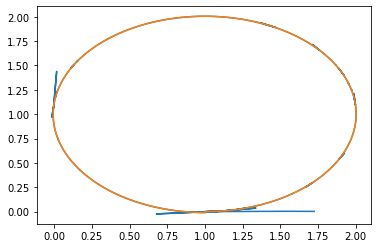

In [174]:
plot(xe_x,xe_y)
plot(xr_x,xr_y)

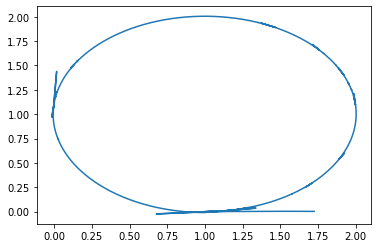

In [175]:
plot(xe_x,xe_y)